In [1]:
import os
os.environ["DEVELOPMENT"] = '1'

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent,IrrigationManagement
from aquacrop.utils import prepare_weather, get_filepath
import pandas as pd
import numpy as np

INFO:root:Running the simulation in development mode.
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
C:\Users\tygt1\anaconda3\lib\site-packages\setuptools\_distutils\_msvccompiler.py:563: UserWarning: Fallback spawn triggered. Please update distutils monkeypatch.
  warnings.warn("Fallback spawn triggered. Please update distutils monkeypatch.")


## Soil fertility calibration

In [2]:
weather_file_path = get_filepath('cordaba_climate.txt')

In [37]:
#don't change this number during testing, unless you will change the AQ-Win accordingly
Rel=60
RedaCCx=77
CCx=96

IrrMethod=0#o rainfed, 4 irrigation
stress=72#give the value shown in AquaCrop-windows interface for test

In [38]:
irrMet=IrrigationManagement(irrigation_method=IrrMethod,NetIrrSMT=80)

wheat = Crop('MaizeGDDAQTEST', planting_date='05/01',need_calib=1,RelativeBio=Rel/100,Ksccx_in=RedaCCx/CCx,fcdecline_in=1,
            sfertstress=stress/100)

model_os = AquaCropModel(
            sim_start_time=f'{1986}/05/01',
            sim_end_time=f'{1986}/08/30',
            weather_df=prepare_weather(weather_file_path),
            soil=Soil(soil_type='SandyLoam'),
            crop=wheat,
            initial_water_content=InitialWaterContent(value=['FC']),
            irrigation_management=irrMet
        )
model_os.run_model(till_termination=True)
model_results = model_os.get_crop_growth()

E:\OneDrive - University of Twente\WaterResearch\AquaCrop\AqOSv7\aquacrop\solution\biomass_accumulation.py:136: RuntimeWarning: invalid value encountered in double_scalars
  BioAdj=FracBiomassPotSF+FracBiomassPotSF-NewCond_B/(Crop.Bio_top[NewCond_DAP]*WPadj)


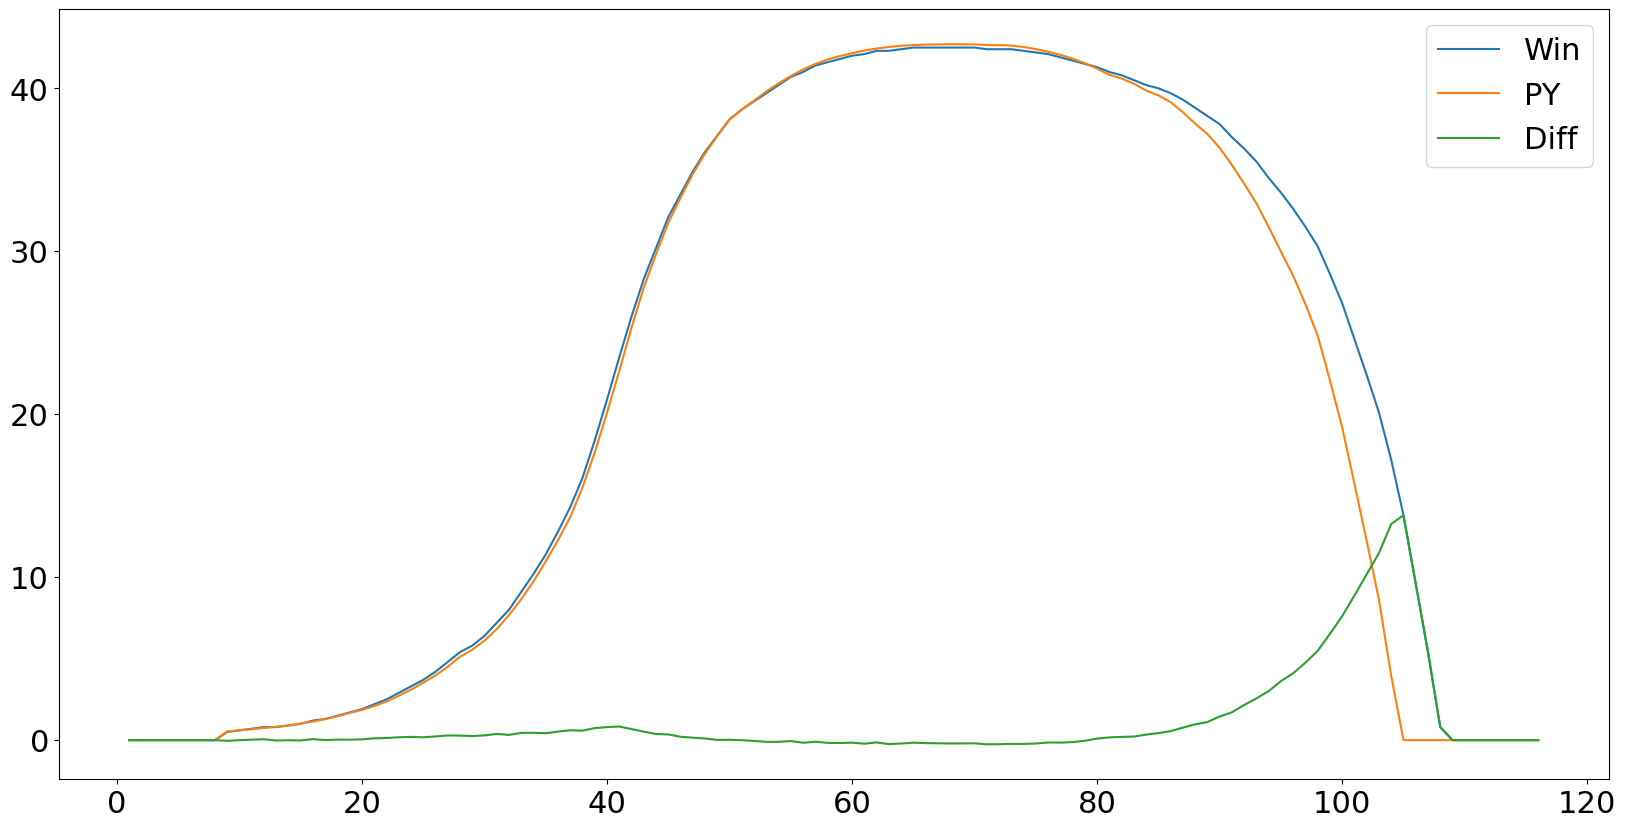

<Figure size 640x480 with 0 Axes>

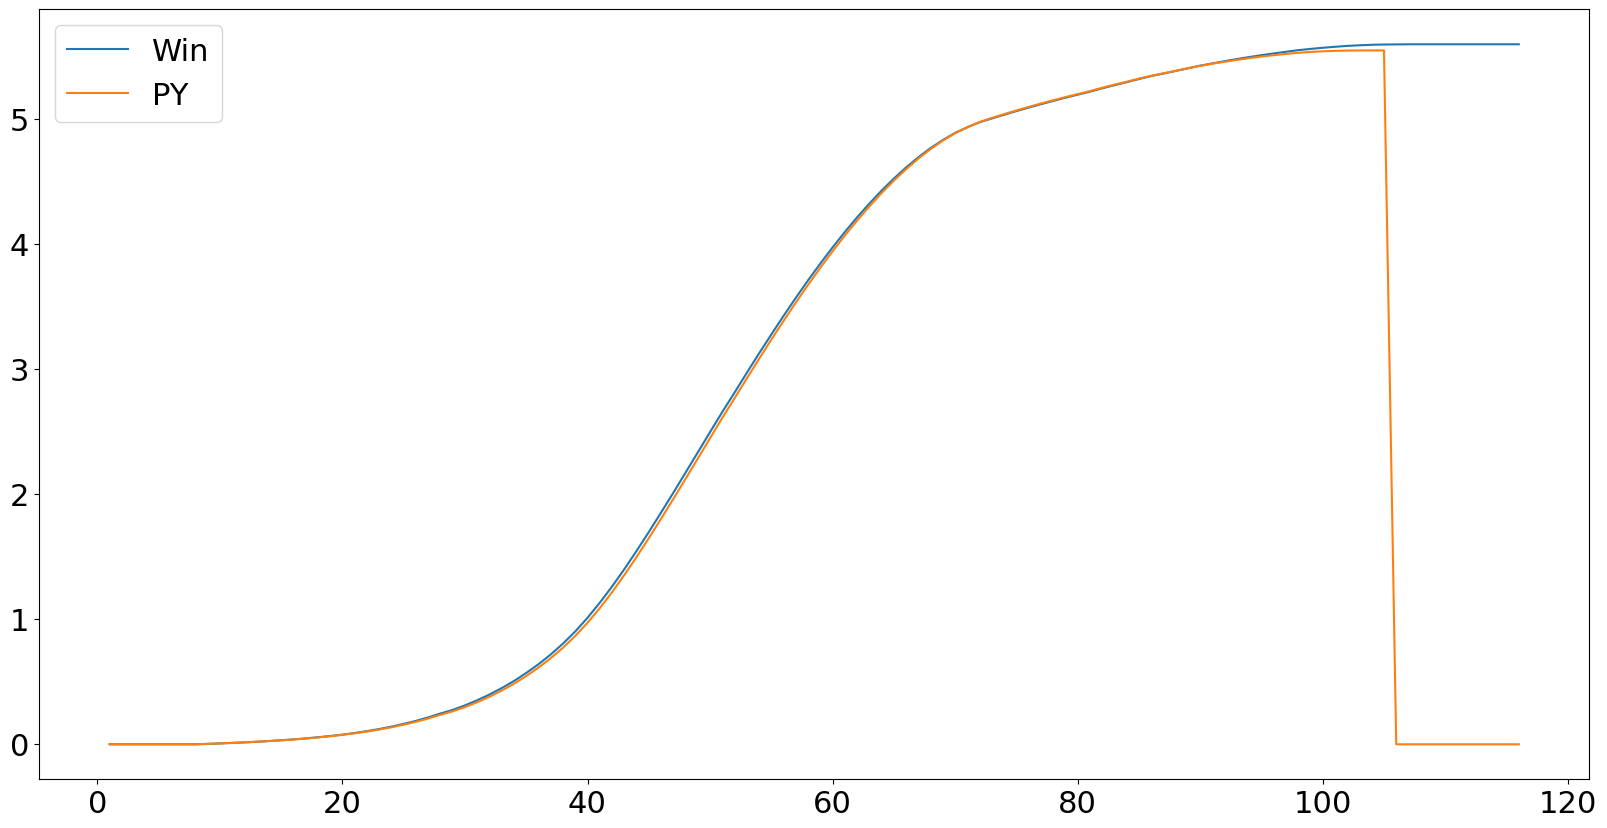

<Figure size 640x480 with 0 Axes>

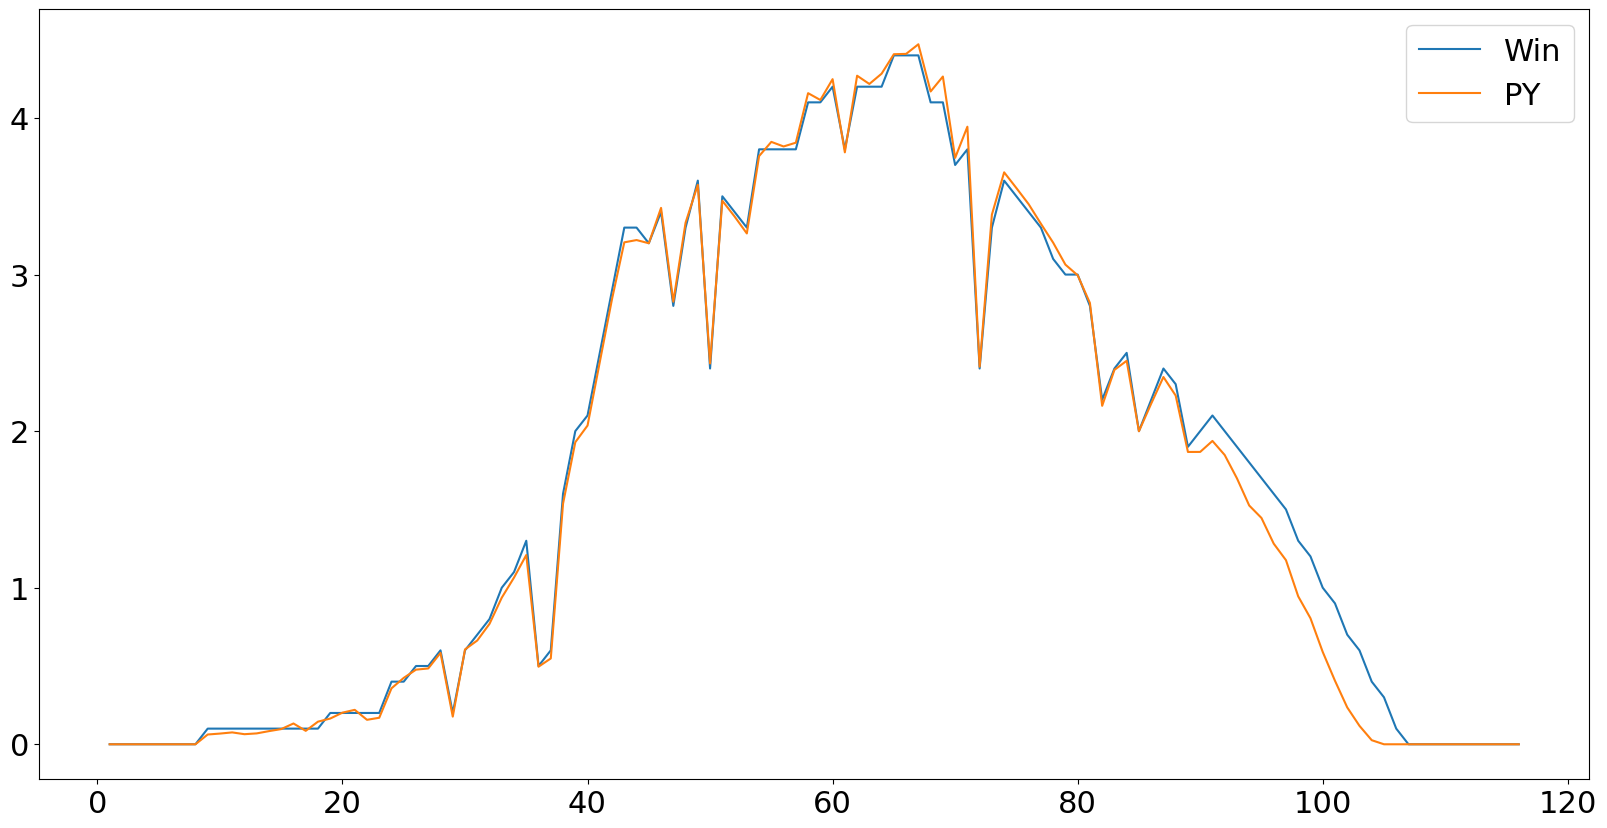

<Figure size 640x480 with 0 Axes>

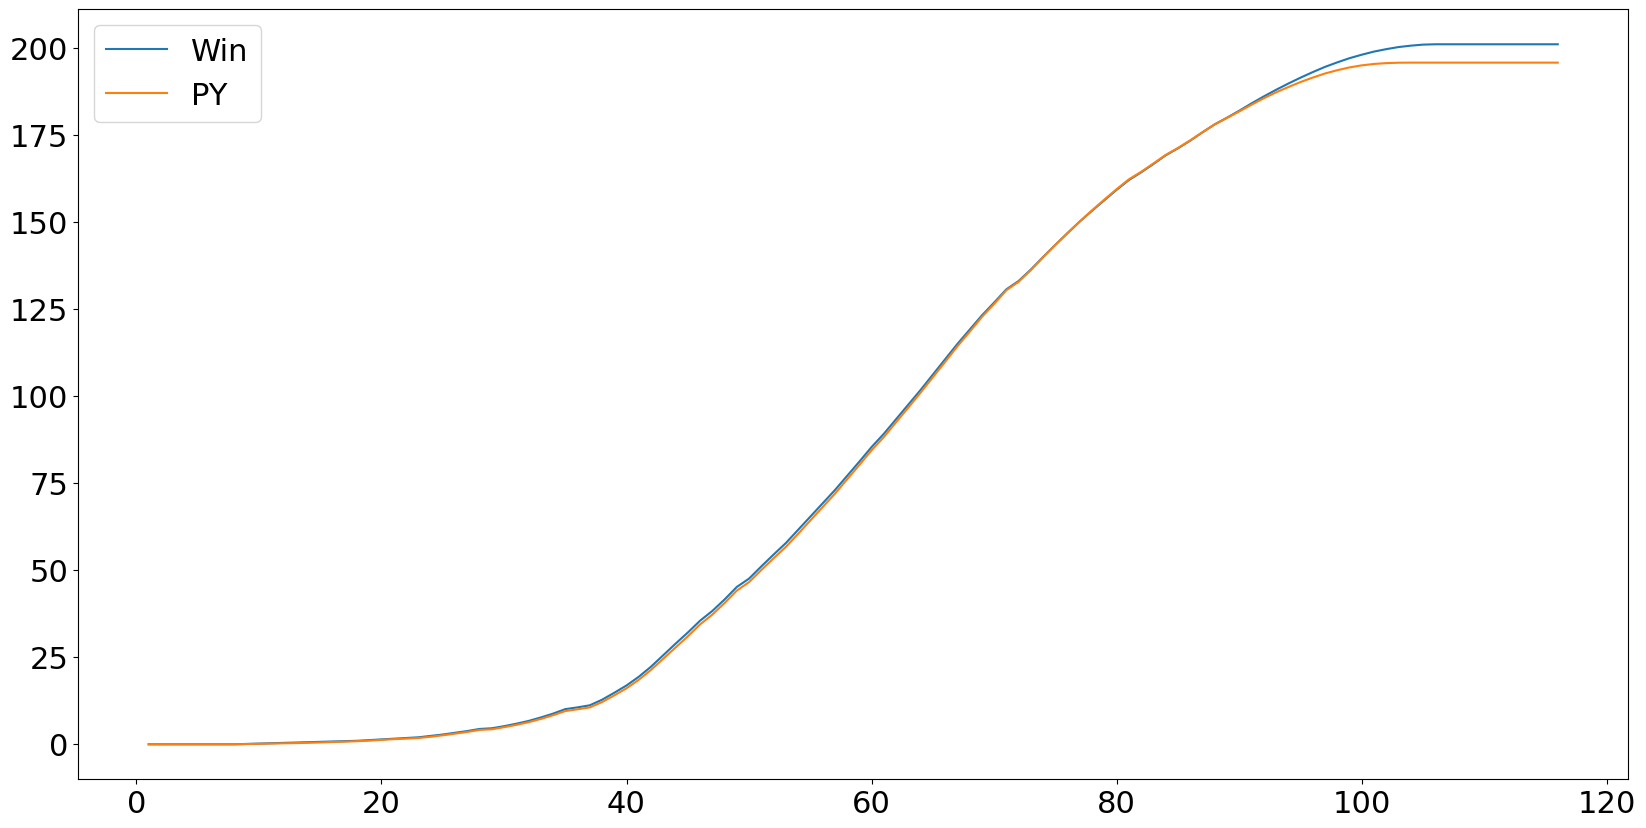

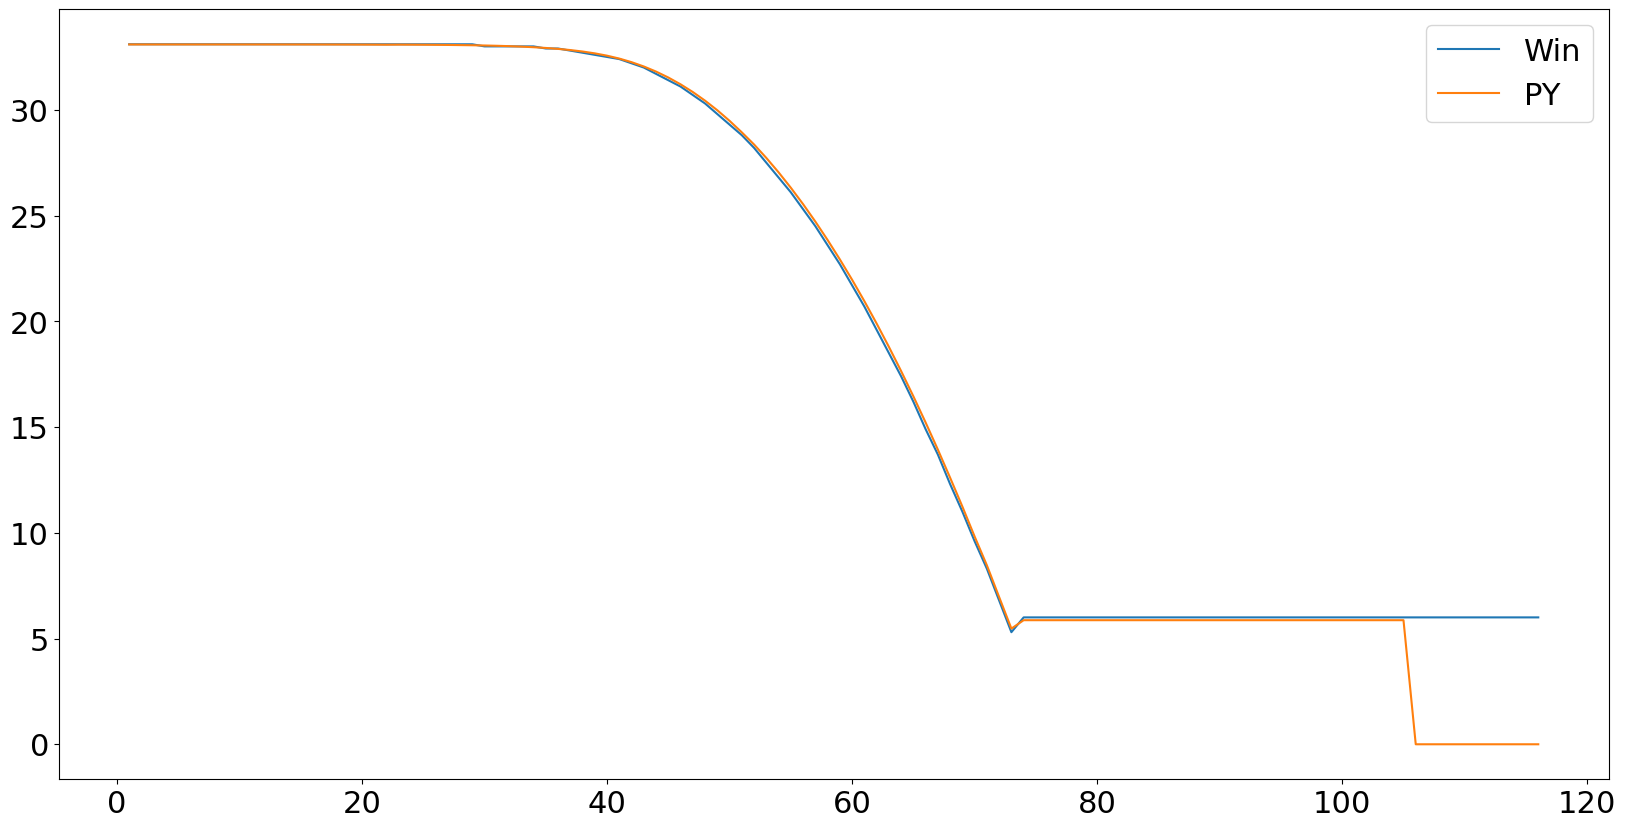

In [39]:
aq=pd.read_table('AquaCropV71No13102023\SIMUL\Crop.OUT',skiprows=4, delim_whitespace=True,encoding="latin1")
aq=aq.drop([0])

aq.to_csv('aq_temp.csv')

aq=pd.read_csv('aq_temp.csv')

import matplotlib.pyplot as plt

aq

time=np.array(range(1,len(aq.index)))
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'CC'],label='Win')
plt.plot(time,model_results.loc[time,'canopy_cover']*100,label='PY')
plt.plot(time,aq.loc[time,'CC']-model_results.loc[time,'canopy_cover']*100,label='Diff')
plt.legend()
plt.savefig('test_figs\maize_CCx_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Biomass'],label='Win')
plt.plot(time,model_results.loc[time,'biomass']/100,label='PY')
plt.legend()
plt.savefig('test_figs\maize_Biomass_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Tr'],label='Win')
plt.plot(time,model_results.loc[time,'Tr'],label='PY')
plt.legend()

import itertools
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,list(itertools.accumulate(aq.loc[time,'Tr'])),label='Win')
plt.plot(time,list(itertools.accumulate(model_results.loc[time,'Tr'])),label='PY')
plt.legend()
plt.savefig('test_figs\maize_Traccum_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

#time=range(1,175)
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'WP'],label='Win')
plt.plot(time,model_results.loc[time,'NewCond.WPadj'],label='PY')
plt.legend()
plt.savefig('test_figs\maize_WPadj_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

In [ ]:
num=np.argmin(Ksexpf_es<1)

Ksexpf_es=model_os.crop.Ksexpf_es[0:num]
fcdecline_es=model_os.crop.fcdecline_es[0:num]
Kswp_es=model_os.crop.Kswp_es[0:num]

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=Ksexpf_es,
    y=fcdecline_es,
    z=Kswp_es,
    mode='markers',
    marker=dict(
        size=12,
        color=Kswp_es,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
import matplotlib.pyplot as plt

time=np.array(range(1,120))
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,model_results.loc[time,'canopy_cover']*100,label='PY')
plt.legend()
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,model_results.loc[time,'biomass']/100,label='PY')
plt.legend()
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,model_results.loc[time,'Tr'],label='PY')
plt.legend()

import itertools
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,list(itertools.accumulate(model_results.loc[time,'Tr'])),label='PY')
plt.legend()
plt.show()

#time=range(1,175)
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,model_results.loc[time,'NewCond.WPadj'],label='PY')
plt.legend()
plt.show()